In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/project/metadata (2).csv
/kaggle/input/project/abundances (2).xlsx


load in data sets
delete patietns that dont have matched tumor and healthy sample
calculate ratio in protein expression per protein and patietn
merge the outcome of 

Code with normal log regression no hyperparameters

In [10]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Load datasets
metadata = pd.read_csv('/kaggle/input/project/metadata (2).csv')
abundance_df = pd.read_excel('/kaggle/input/project/abundances (2).xlsx')

# Identify healthy (L*P) and tumor (L*T) columns
healthy_columns = [col for col in abundance_df.columns if col.endswith("P")]
tumor_columns = [col for col in abundance_df.columns if col.endswith("T")]

# Find common patient IDs
common_ids = set(col[:-1] for col in healthy_columns).intersection(set(col[:-1] for col in tumor_columns))

# Filter matched columns
matched_healthy_columns = [col for col in healthy_columns if col[:-1] in common_ids]
matched_tumor_columns = [col for col in tumor_columns if col[:-1] in common_ids]

# Compute ratios for each matched patient
for healthy_col in matched_healthy_columns:
    tumor_col = healthy_col.replace("P", "T")
    patient_id = healthy_col[:-1]
    abundance_df[f'ratio_{patient_id}'] = (
        abundance_df[tumor_col] / abundance_df[healthy_col]
    ).replace([float('inf'), -float('inf')], pd.NA)  # Replace division errors with NaN

# Create a wide-format DataFrame with patient IDs as rows
ratio_df = abundance_df[[col for col in abundance_df.columns if col.startswith('ratio_')]].T
ratio_df.columns = abundance_df['Symbol']
ratio_df.index = [col.replace('ratio_', '') for col in ratio_df.index]
ratio_df.index.name = 'Patient_ID'

# Merge with metadata to include Recurr_status
metadata = metadata.rename(columns={'ID': 'Patient_ID'})
merged_df = ratio_df.merge(metadata[['Patient_ID', 'Recurr_status']], on='Patient_ID')

# Separate features (protein ratios) and target (Recurr_status)
X = merged_df.drop(columns=['Recurr_status'])  # Drop the target column
y = merged_df['Recurr_status']                # Target variable

# Remove the Patient_ID column from features
X = X.drop(columns=['Patient_ID'])

# Ensure all column names are strings
X.columns = X.columns.astype(str)

# Impute missing values in X with the median
imputer = SimpleImputer(strategy='median')
X = imputer.fit_transform(X)

# Proceed with train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train logistic regression model with class weights
model = LogisticRegression(class_weight='balanced', random_state=42)
model.fit(X_train_scaled, y_train)

# Predict and evaluate
y_pred = model.predict(X_test_scaled)

print("\nClassification Report (Using Class Weights):")
print(classification_report(y_test, y_pred))

print("Confusion Matrix (Using Class Weights):")
print(confusion_matrix(y_test, y_pred))

print("Accuracy Score (Using Class Weights):", accuracy_score(y_test, y_pred))


Classification Report (Using Class Weights):
              precision    recall  f1-score   support

           0       0.76      0.87      0.81        15
           1       0.33      0.20      0.25         5

    accuracy                           0.70        20
   macro avg       0.55      0.53      0.53        20
weighted avg       0.66      0.70      0.67        20

Confusion Matrix (Using Class Weights):
[[13  2]
 [ 4  1]]
Accuracy Score (Using Class Weights): 0.7


In [2]:
merged_df

,Patient_ID,STBD1,HPD,GSTZ1,ADH1B,GPD1,PHYKPL,ASPDH,DMGDH,FMO3,...,GLDC,PHYH,ATPAF1,DCAKD,RGN,SCO2,ACOT8,COQ3,TMEM245,Recurr_status
0,L076,1.994329,0.270246,0.560694,2.088795,1.661566,0.923269,0.362712,0.432275,0.716727,...,1.782068,1.775315,0.544965,0.415538,1.151860,2.438713,8.093244,NaN,NaN,1
1,L057,1.888218,0.733746,0.737107,1.273745,0.812609,0.763448,0.637852,1.136356,2.078608,...,0.428568,0.998131,2.320889,1.282868,0.926258,0.707507,1.736628,1.270009,2.490519,1
2,L058,1.588110,0.622225,0.274530,0.420113,0.701164,1.273416,0.552412,0.321088,0.865141,...,2.061837,0.365784,1.465793,0.575029,0.453269,1.227361,2.665243,0.964604,1.418871,0
3,L066,1.441408,1.346855,0.550404,0.764171,0.729915,0.620556,0.310430,0.586330,1.631543,...,0.004680,1.172712,0.927498,7.470065,1.051874,0.344052,1.506546,0.824048,4.195782,0
4,L063,0.838275,1.629300,0.703096,0.904632,0.725431,0.117736,1.031828,1.933261,2.237035,...,0.242072,1.388131,1.950291,30.986248,0.651220,1.731400,12.440733,1.049824,1.003996,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,L090,0.029838,0.037286,0.126155,0.104855,0.040498,0.079924,0.009310,0.037900,0.053667,...,0.035112,0.031342,0.481233,0.800000,0.042976,0.112042,7.549518,0.149894,0.440858,1
94,L098,0.405969,0.079932,0.115452,0.113292,0.078828,0.045400,0.023187,0.111160,0.155265,...,0.187187,0.140630,0.408834,0.677530,0.328631,3.486407,5.976406,0.653034,0.984506,1
95,L102,0.013380,0.027731,0.101136,0.072883,0.010122,0.127293,0.020245,0.000331,0.056283,...,0.029469,0.037675,0.206479,1.387778,0.093745,1.014869,0.315892,0.117405,1.762460,0
96,L104,0.373072,0.284405,0.086838,0.461432,0.286587,0.099543,0.192559,0.126484,0.321039,...,0.291334,0.346047,0.880538,0.243037,0.305537,1.449701,1.509740,0.513871,0.924502,0


log regression + defining optimal hyperparameters

In [3]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

# Load datasets
metadata = pd.read_csv('/kaggle/input/project/metadata (2).csv')
abundance_df = pd.read_excel('/kaggle/input/project/abundances (2).xlsx')

# Identify healthy (L*P) and tumor (L*T) columns
healthy_columns = [col for col in abundance_df.columns if col.endswith("P")]
tumor_columns = [col for col in abundance_df.columns if col.endswith("T")]

# Find common patient IDs
common_ids = set(col[:-1] for col in healthy_columns).intersection(set(col[:-1] for col in tumor_columns))

# Filter matched columns
matched_healthy_columns = [col for col in healthy_columns if col[:-1] in common_ids]
matched_tumor_columns = [col for col in tumor_columns if col[:-1] in common_ids]

# Compute ratios for each matched patient
for healthy_col in matched_healthy_columns:
    tumor_col = healthy_col.replace("P", "T")
    patient_id = healthy_col[:-1]
    abundance_df[f'ratio_{patient_id}'] = (
        abundance_df[tumor_col] / abundance_df[healthy_col]
    ).replace([float('inf'), -float('inf')], pd.NA)  # Replace division errors with NaN

# Create a wide-format DataFrame with patient IDs as rows
ratio_df = abundance_df[[col for col in abundance_df.columns if col.startswith('ratio_')]].T
ratio_df.columns = abundance_df['Symbol']
ratio_df.index = [col.replace('ratio_', '') for col in ratio_df.index]
ratio_df.index.name = 'Patient_ID'

# Merge with metadata to include Recurr_status
metadata = metadata.rename(columns={'ID': 'Patient_ID'})
merged_df = ratio_df.merge(metadata[['Patient_ID', 'Recurr_status']], on='Patient_ID')

# Separate features (protein ratios) and target (Recurr_status)
X = merged_df.drop(columns=['Recurr_status'])  # Drop the target column
y = merged_df['Recurr_status']                # Target variable

# Remove the Patient_ID column from features
X = X.drop(columns=['Patient_ID'])

# Ensure all column names are strings
X.columns = X.columns.astype(str)

# Impute missing values in X with the median
imputer = SimpleImputer(strategy='median')
X = imputer.fit_transform(X)

# Proceed with train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['lbfgs', 'liblinear'],
    'penalty': ['l2'],
    'max_iter': [100, 200, 500]
}

# logistic regression (with class_weight = 'balanced') outperformed decison tree, XGBoost and random forest with SMOTE for class imbalance. class weight> smote for lin regression
# Create a logistic regression model
model = LogisticRegression(class_weight='balanced', random_state=42)

#
# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    verbose=1,
    n_jobs=-1
)

# Perform the grid search
grid_search.fit(X_train_scaled, y_train)

# Output the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

# Train the best model
best_model = grid_search.best_estimator_
best_model.fit(X_train_scaled, y_train)

# Prediction and evaluation on the test set
y_pred = best_model.predict(X_test_scaled)
print("\nClassification Report (Best Model):")
print(classification_report(y_test, y_pred))
print("Confusion Matrix (Best Model):")
print(confusion_matrix(y_test, y_pred))
print("Accuracy Score (Best Model):", accuracy_score(y_test, y_pred))

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Parameters: {'C': 0.01, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
Best Cross-Validation Score: 0.48666666666666664

Classification Report (Best Model):
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        15
           1       0.40      0.40      0.40         5

    accuracy                           0.70        20
   macro avg       0.60      0.60      0.60        20
weighted avg       0.70      0.70      0.70        20

Confusion Matrix (Best Model):
[[12  3]
 [ 3  2]]
Accuracy Score (Best Model): 0.7


tot hier geen rekening gehouden met missing values

In [4]:
# Calculate percentage of missing values per protein
missing_percentages = ratio_df.isnull().mean() * 100

# Display missing percentages
print("Percentage of Missing Values per Protein:")
print(missing_percentages)

Percentage of Missing Values per Protein:
Symbol
SULT1B1    22.448980
SLC22A1    47.959184
STBD1       0.000000
HPD         1.020408
GSTZ1       0.000000
             ...    
COQ3        2.040816
PLIN5      43.877551
NUDT8      23.469388
TMEM245     8.163265
SLC22A7    30.612245
Length: 1269, dtype: float64


% missing value per eiwit gevisualiseerd in boxplot, online zeggen ze dat meer dan 20% missing data niet echt bruikbaar is aangezien uw data dan te vervormmd is door imputing

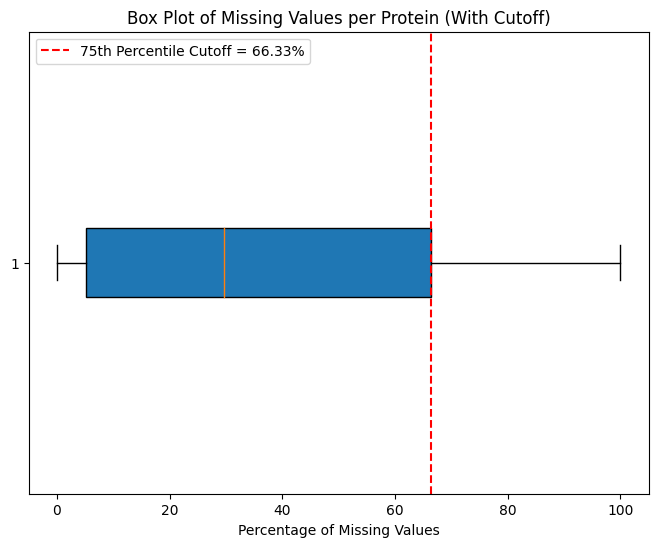

The cutoff for the highest quartile (75th percentile) is 66.33%


In [27]:
# Calculate cutoff for the highest quartile (75th percentile)
cutoff = missing_percentages.quantile(0.75)

# Box plot with cutoff line
plt.figure(figsize=(8, 6))
plt.boxplot(missing_percentages, vert=False, patch_artist=True)
plt.axvline(cutoff, color='red', linestyle='--', label=f"75th Percentile Cutoff = {cutoff:.2f}%")
plt.title("Box Plot of Missing Values per Protein (With Cutoff)")
plt.xlabel("Percentage of Missing Values")


plt.legend()
plt.show()

# Display the cutoff value
print(f"The cutoff for the highest quartile (75th percentile) is {cutoff:.2f}%")

**stuk code hieronder Dit is eignelijk de code die het "optimale" model traint.**
- lineair regression model is beste model
- geoptimaliseerde hyperparameters
- 15% missing vallue treshold lijkt een goeie waarde**

In [1]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV

# Load datasets
metadata = pd.read_csv('/kaggle/input/project/metadata (2).csv')
abundance_df = pd.read_excel('/kaggle/input/project/abundances (2).xlsx')

# Identify healthy (L*P) and tumor (L*T) columns
healthy_columns = [col for col in abundance_df.columns if col.endswith("P")]
tumor_columns = [col for col in abundance_df.columns if col.endswith("T")]

# Find common patient IDs
common_ids = set(col[:-1] for col in healthy_columns).intersection(set(col[:-1] for col in tumor_columns))

# Filter matched columns
matched_healthy_columns = [col for col in healthy_columns if col[:-1] in common_ids]
matched_tumor_columns = [col for col in tumor_columns if col[:-1] in common_ids]

# Compute ratios for each matched patient
for healthy_col in matched_healthy_columns:
    tumor_col = healthy_col.replace("P", "T")
    patient_id = healthy_col[:-1]
    abundance_df[f'ratio_{patient_id}'] = (
        abundance_df[tumor_col] / abundance_df[healthy_col]
    ).replace([float('inf'), -float('inf')], pd.NA)  # Replace division errors with NaN

# Create a wide-format DataFrame with patient IDs as rows
ratio_df = abundance_df[[col for col in abundance_df.columns if col.startswith('ratio_')]].T
ratio_df.columns = abundance_df['Symbol']
ratio_df.index = [col.replace('ratio_', '') for col in ratio_df.index]
ratio_df.index.name = 'Patient_ID'

# Filter out proteins with more than 66.33% missing values
missing_percentages = ratio_df.isnull().mean() * 100
filtered_ratio_df = ratio_df.loc[:, missing_percentages <= 15]
print(f"Number of Proteins Before Filtering: {ratio_df.shape[1]}")
print(f"Number of Proteins After Filtering: {filtered_ratio_df.shape[1]}")

# Merge with metadata to include Recurr_status
metadata = metadata.rename(columns={'ID': 'Patient_ID'})
merged_df = filtered_ratio_df.merge(metadata[['Patient_ID', 'Recurr_status']], on='Patient_ID')

# Separate features (protein ratios) and target (Recurr_status)
X = merged_df.drop(columns=['Recurr_status'])  # Drop the target column
y = merged_df['Recurr_status']                # Target variable

# Remove the Patient_ID column from features
X = X.drop(columns=['Patient_ID'])

# Ensure all column names are strings
X.columns = X.columns.astype(str)

# Impute missing values in X with the median
imputer = SimpleImputer(strategy='median')
X = imputer.fit_transform(X)

# Proceed with train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['lbfgs', 'liblinear'],
    'penalty': ['l2'],
    'max_iter': [100, 200, 500]
}

# Create a logistic regression model
model = LogisticRegression(class_weight='balanced', random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    verbose=1,
    n_jobs=-1
)

# Perform the grid search
grid_search.fit(X_train_scaled, y_train)

# Output the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

# Train the best model
best_model = grid_search.best_estimator_
best_model.fit(X_train_scaled, y_train)

# Prediction and evaluation on the test set
y_pred = best_model.predict(X_test_scaled)
print("\nClassification Report (Best Model):")
print(classification_report(y_test, y_pred))
print("Confusion Matrix (Best Model):")
print(confusion_matrix(y_test, y_pred))
print("Accuracy Score (Best Model):", accuracy_score(y_test, y_pred))


Number of Proteins Before Filtering: 1269
Number of Proteins After Filtering: 471
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Parameters: {'C': 0.1, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
Best Cross-Validation Score: 0.48583333333333334

Classification Report (Best Model):
              precision    recall  f1-score   support

           0       0.86      0.80      0.83        15
           1       0.50      0.60      0.55         5

    accuracy                           0.75        20
   macro avg       0.68      0.70      0.69        20
weighted avg       0.77      0.75      0.76        20

Confusion Matrix (Best Model):
[[12  3]
 [ 2  3]]
Accuracy Score (Best Model): 0.75


3 stukken code hierhonder vergelijkt linear regression model met 2 andere soort modelen en geeft per model optimale treshold voor missing values


Results of F1 Scores and Accuracy for Different Thresholds:
    Threshold  F1_Class_0  F1_Class_1  Accuracy
0         0.0    0.827586    0.545455      0.75
1         2.5    0.814815    0.615385      0.75
2         5.0    0.785714    0.500000      0.70
3         7.5    0.769231    0.571429      0.70
4        10.0    0.827586    0.545455      0.75
5        12.5    0.785714    0.500000      0.70
6        15.0    0.827586    0.545455      0.75
7        17.5    0.838710    0.444444      0.75
8        20.0    0.838710    0.444444      0.75
9        22.5    0.758621    0.363636      0.65
10       25.0    0.758621    0.363636      0.65
11       27.5    0.733333    0.200000      0.60
12       30.0    0.758621    0.363636      0.65
13       32.5    0.800000    0.400000      0.70
14       35.0    0.812500    0.250000      0.70
15       37.5    0.812500    0.250000      0.70
16       40.0    0.733333    0.200000      0.60
17       42.5    0.774194    0.222222      0.65
18       45.0    0.774194   

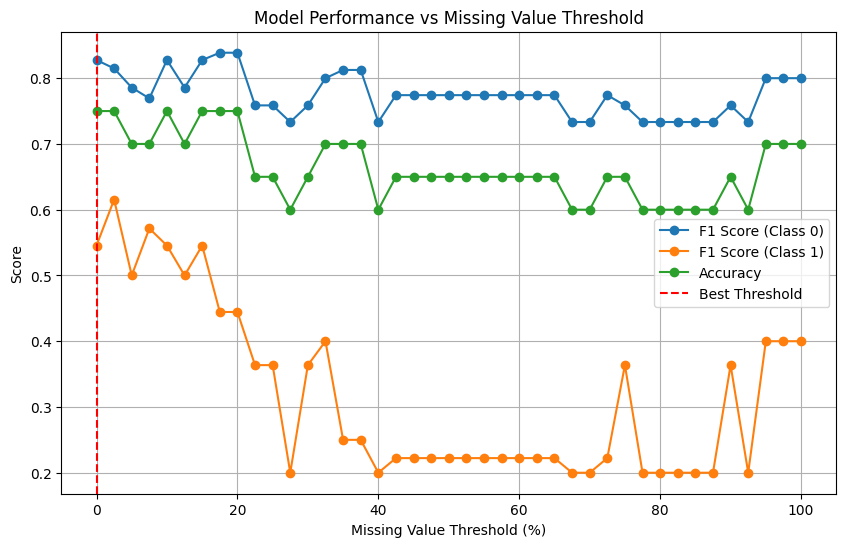

In [49]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

# Load datasets
metadata = pd.read_csv('/kaggle/input/project/metadata (2).csv')
abundance_df = pd.read_excel('/kaggle/input/project/abundances (2).xlsx')

# Identify healthy (L*P) and tumor (L*T) columns
healthy_columns = [col for col in abundance_df.columns if col.endswith("P")]
tumor_columns = [col for col in abundance_df.columns if col.endswith("T")]

# Find common patient IDs
common_ids = set(col[:-1] for col in healthy_columns).intersection(set(col[:-1] for col in tumor_columns))

# Filter matched columns
matched_healthy_columns = [col for col in healthy_columns if col[:-1] in common_ids]
matched_tumor_columns = [col for col in tumor_columns if col[:-1] in common_ids]

# Compute ratios for each matched patient
for healthy_col in matched_healthy_columns:
    tumor_col = healthy_col.replace("P", "T")
    patient_id = healthy_col[:-1]
    abundance_df[f'ratio_{patient_id}'] = (
        abundance_df[tumor_col] / abundance_df[healthy_col]
    ).replace([float('inf'), -float('inf')], pd.NA)  # Replace division errors with NaN

# Create a wide-format DataFrame with patient IDs as rows
ratio_df = abundance_df[[col for col in abundance_df.columns if col.startswith('ratio_')]].T
ratio_df.columns = abundance_df['Symbol']
ratio_df.index = [col.replace('ratio_', '') for col in ratio_df.index]
ratio_df.index.name = 'Patient_ID'

# Merge with metadata to include Recurr_status
metadata = metadata.rename(columns={'ID': 'Patient_ID'})

# Initialize storage for results
results = []

# Loop over thresholds for missing values
for threshold in np.arange(0, 100.1, 2.5):
    # Filter out proteins with more than the threshold percentage of missing values
    missing_percentages = ratio_df.isnull().mean() * 100
    filtered_ratio_df = ratio_df.loc[:, missing_percentages <= threshold]
    
    # Merge with metadata
    merged_df = filtered_ratio_df.merge(metadata[['Patient_ID', 'Recurr_status']], on='Patient_ID')

    # Separate features (protein ratios) and target (Recurr_status)
    X = merged_df.drop(columns=['Recurr_status'])
    y = merged_df['Recurr_status']

    # Remove the Patient_ID column from features
    X = X.drop(columns=['Patient_ID'])

    # Ensure all column names are strings
    X.columns = X.columns.astype(str)

    # Impute missing values in X with the median
    imputer = SimpleImputer(strategy='median')
    X = imputer.fit_transform(X)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Hyperparameter tuning using GridSearchCV
    param_grid = {
        'C': [0.01, 0.1, 1, 10, 100],
        'solver': ['lbfgs', 'liblinear'],
        'penalty': ['l2'],
        'max_iter': [100, 200, 500]
    }

    # Create a logistic regression model
    model = LogisticRegression(class_weight='balanced', random_state=42)

    # Set up GridSearchCV
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring='accuracy',
        cv=5,
        verbose=0,
        n_jobs=-1
    )

    # Perform the grid search
    grid_search.fit(X_train_scaled, y_train)

    # Train the best model
    best_model = grid_search.best_estimator_
    best_model.fit(X_train_scaled, y_train)

    # Predictions and F1-score
    y_pred = best_model.predict(X_test_scaled)
    f1_class_0 = f1_score(y_test, y_pred, pos_label=0)
    f1_class_1 = f1_score(y_test, y_pred, pos_label=1)
    
    # Store the results
    results.append({
        'Threshold': threshold,
        'F1_Class_0': f1_class_0,
        'F1_Class_1': f1_class_1,
        'Accuracy': accuracy_score(y_test, y_pred)
    })

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Display results
print("Results of F1 Scores and Accuracy for Different Thresholds:")
print(results_df)

# Plot results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(results_df['Threshold'], results_df['F1_Class_0'], label='F1 Score (Class 0)', marker='o')
plt.plot(results_df['Threshold'], results_df['F1_Class_1'], label='F1 Score (Class 1)', marker='o')
plt.plot(results_df['Threshold'], results_df['Accuracy'], label='Accuracy', marker='o')
plt.axvline(results_df.loc[results_df['Accuracy'].idxmax(), 'Threshold'], color='red', linestyle='--', label='Best Threshold')
plt.xlabel("Missing Value Threshold (%)")
plt.ylabel("Score")
plt.title("Model Performance vs Missing Value Threshold")
plt.legend()
plt.grid()
plt.show()




Results of F1 Scores and Accuracy for Different Thresholds:
    Threshold  F1_Class_0  F1_Class_1  Accuracy
0         0.0    0.642857    0.166667      0.50
1         2.5    0.583333    0.375000      0.50
2         5.0    0.545455    0.444444      0.50
3         7.5    0.666667    0.307692      0.55
4        10.0    0.714286    0.333333      0.60
5        12.5    0.666667    0.307692      0.55
6        15.0    0.615385    0.285714      0.50
7        17.5    0.812500    0.250000      0.70
8        20.0    0.812500    0.250000      0.70
9        22.5    0.812500    0.250000      0.70
10       25.0    0.812500    0.250000      0.70
11       27.5    0.812500    0.250000      0.70
12       30.0    0.733333    0.200000      0.60
13       32.5    0.787879    0.000000      0.65
14       35.0    0.787879    0.000000      0.65
15       37.5    0.733333    0.200000      0.60
16       40.0    0.750000    0.000000      0.60
17       42.5    0.774194    0.222222      0.65
18       45.0    0.812500   

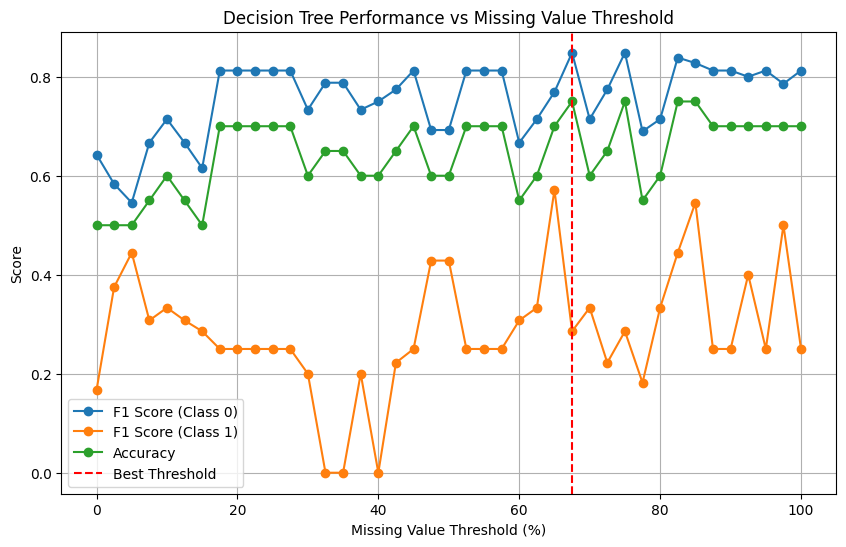

In [50]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import matplotlib.pyplot as plt

# Load datasets
metadata = pd.read_csv('/kaggle/input/project/metadata (2).csv')
abundance_df = pd.read_excel('/kaggle/input/project/abundances (2).xlsx')

# Identify healthy (L*P) and tumor (L*T) columns
healthy_columns = [col for col in abundance_df.columns if col.endswith("P")]
tumor_columns = [col for col in abundance_df.columns if col.endswith("T")]

# Find common patient IDs
common_ids = set(col[:-1] for col in healthy_columns).intersection(set(col[:-1] for col in tumor_columns))

# Filter matched columns
matched_healthy_columns = [col for col in healthy_columns if col[:-1] in common_ids]
matched_tumor_columns = [col for col in tumor_columns if col[:-1] in common_ids]

# Compute ratios for each matched patient
for healthy_col in matched_healthy_columns:
    tumor_col = healthy_col.replace("P", "T")
    patient_id = healthy_col[:-1]
    abundance_df[f'ratio_{patient_id}'] = (
        abundance_df[tumor_col] / abundance_df[healthy_col]
    ).replace([float('inf'), -float('inf')], pd.NA)  # Replace division errors with NaN

# Create a wide-format DataFrame with patient IDs as rows
ratio_df = abundance_df[[col for col in abundance_df.columns if col.startswith('ratio_')]].T
ratio_df.columns = abundance_df['Symbol']
ratio_df.index = [col.replace('ratio_', '') for col in ratio_df.index]
ratio_df.index.name = 'Patient_ID'

# Merge with metadata to include Recurr_status
metadata = metadata.rename(columns={'ID': 'Patient_ID'})

# Initialize storage for results
results = []

# Loop over thresholds for missing values
for threshold in np.arange(0, 100.1, 2.5):
    # Filter out proteins with more than the threshold percentage of missing values
    missing_percentages = ratio_df.isnull().mean() * 100
    filtered_ratio_df = ratio_df.loc[:, missing_percentages <= threshold]
    
    # Merge with metadata
    merged_df = filtered_ratio_df.merge(metadata[['Patient_ID', 'Recurr_status']], on='Patient_ID')

    # Separate features (protein ratios) and target (Recurr_status)
    X = merged_df.drop(columns=['Recurr_status'])
    y = merged_df['Recurr_status']

    # Remove the Patient_ID column from features
    X = X.drop(columns=['Patient_ID'])

    # Ensure all column names are strings
    X.columns = X.columns.astype(str)

    # Impute missing values in X with the median
    imputer = SimpleImputer(strategy='median')
    X = imputer.fit_transform(X)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Hyperparameter tuning using GridSearchCV for Decision Tree
    param_grid = {
        'criterion': ['gini', 'entropy'],
        'max_depth': [None, 5, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 5]
    }

    # Create a decision tree classifier
    model = DecisionTreeClassifier(random_state=42, class_weight='balanced')

    # Set up GridSearchCV
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring='accuracy',
        cv=5,
        verbose=0,
        n_jobs=-1
    )

    # Perform the grid search
    grid_search.fit(X_train, y_train)

    # Train the best model
    best_model = grid_search.best_estimator_
    best_model.fit(X_train, y_train)

    # Predictions and F1-score
    y_pred = best_model.predict(X_test)
    f1_class_0 = f1_score(y_test, y_pred, pos_label=0)
    f1_class_1 = f1_score(y_test, y_pred, pos_label=1)
    
    # Store the results
    results.append({
        'Threshold': threshold,
        'F1_Class_0': f1_class_0,
        'F1_Class_1': f1_class_1,
        'Accuracy': accuracy_score(y_test, y_pred)
    })

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Display results
print("Results of F1 Scores and Accuracy for Different Thresholds:")
print(results_df)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(results_df['Threshold'], results_df['F1_Class_0'], label='F1 Score (Class 0)', marker='o')
plt.plot(results_df['Threshold'], results_df['F1_Class_1'], label='F1 Score (Class 1)', marker='o')
plt.plot(results_df['Threshold'], results_df['Accuracy'], label='Accuracy', marker='o')
plt.axvline(results_df.loc[results_df['Accuracy'].idxmax(), 'Threshold'], color='red', linestyle='--', label='Best Threshold')
plt.xlabel("Missing Value Threshold (%)")
plt.ylabel("Score")
plt.title("Decision Tree Performance vs Missing Value Threshold")
plt.legend()
plt.grid()
plt.show()

Results of F1 Scores and Accuracy for Different Thresholds:
    Threshold  F1_Class_0  F1_Class_1  Accuracy
0         0.0    0.758621    0.363636      0.65
1         2.5    0.774194    0.222222      0.65
2         5.0    0.774194    0.222222      0.65
3         7.5    0.733333    0.200000      0.60
4        10.0    0.787879    0.000000      0.65
5        12.5    0.750000    0.000000      0.60
6        15.0    0.774194    0.222222      0.65
7        17.5    0.787879    0.000000      0.65
8        20.0    0.787879    0.000000      0.65
9        22.5    0.750000    0.000000      0.60
10       25.0    0.750000    0.000000      0.60
11       27.5    0.812500    0.250000      0.70
12       30.0    0.750000    0.000000      0.60
13       32.5    0.787879    0.000000      0.65
14       35.0    0.709677    0.000000      0.55
15       37.5    0.812500    0.250000      0.70
16       40.0    0.787879    0.000000      0.65
17       42.5    0.709677    0.000000      0.55
18       45.0    0.787879   

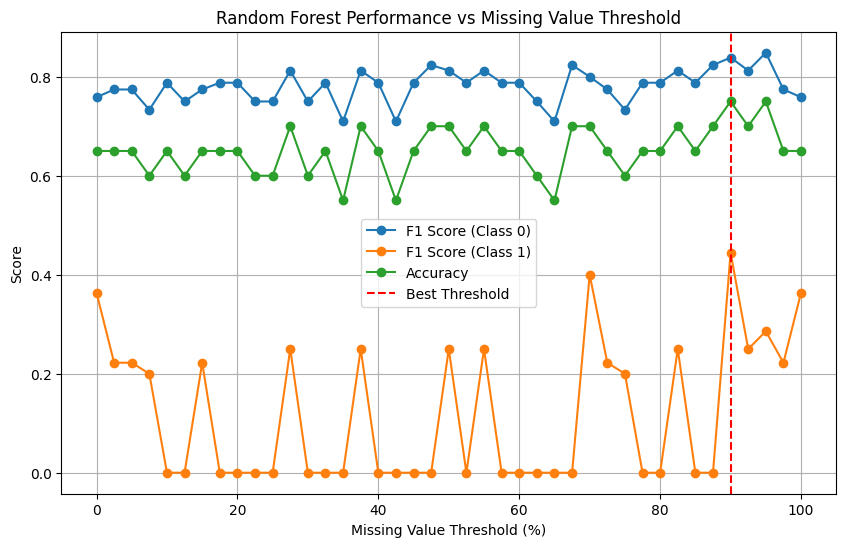

In [52]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import matplotlib.pyplot as plt

# Load datasets
metadata = pd.read_csv('/kaggle/input/project/metadata (2).csv')
abundance_df = pd.read_excel('/kaggle/input/project/abundances (2).xlsx')

# Identify healthy (L*P) and tumor (L*T) columns
healthy_columns = [col for col in abundance_df.columns if col.endswith("P")]
tumor_columns = [col for col in abundance_df.columns if col.endswith("T")]

# Find common patient IDs
common_ids = set(col[:-1] for col in healthy_columns).intersection(set(col[:-1] for col in tumor_columns))

# Filter matched columns
matched_healthy_columns = [col for col in healthy_columns if col[:-1] in common_ids]
matched_tumor_columns = [col for col in tumor_columns if col[:-1] in common_ids]

# Compute ratios for each matched patient
for healthy_col in matched_healthy_columns:
    tumor_col = healthy_col.replace("P", "T")
    patient_id = healthy_col[:-1]
    abundance_df[f'ratio_{patient_id}'] = (
        abundance_df[tumor_col] / abundance_df[healthy_col]
    ).replace([float('inf'), -float('inf')], pd.NA)  # Replace division errors with NaN

# Create a wide-format DataFrame with patient IDs as rows
ratio_df = abundance_df[[col for col in abundance_df.columns if col.startswith('ratio_')]].T
ratio_df.columns = abundance_df['Symbol']
ratio_df.index = [col.replace('ratio_', '') for col in ratio_df.index]
ratio_df.index.name = 'Patient_ID'

# Merge with metadata to include Recurr_status
metadata = metadata.rename(columns={'ID': 'Patient_ID'})

# Initialize storage for results
results = []

# Loop over thresholds for missing values
for threshold in np.arange(0, 100.1, 2.5):
    # Filter out proteins with more than the threshold percentage of missing values
    missing_percentages = ratio_df.isnull().mean() * 100
    filtered_ratio_df = ratio_df.loc[:, missing_percentages <= threshold]
    
    # Merge with metadata
    merged_df = filtered_ratio_df.merge(metadata[['Patient_ID', 'Recurr_status']], on='Patient_ID')

    # Separate features (protein ratios) and target (Recurr_status)
    X = merged_df.drop(columns=['Recurr_status'])
    y = merged_df['Recurr_status']

    # Remove the Patient_ID column from features
    X = X.drop(columns=['Patient_ID'])

    # Ensure all column names are strings
    X.columns = X.columns.astype(str)

    # Impute missing values in X with the median
    imputer = SimpleImputer(strategy='median')
    X = imputer.fit_transform(X)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Hyperparameter tuning using GridSearchCV for Random Forest
    param_grid = {
        'n_estimators': [100,200,300],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 5],
        'class_weight': ['balanced']
    }

    # Create a random forest classifier
    model = RandomForestClassifier(random_state=42)

    # Set up GridSearchCV
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring='accuracy',
        cv=5,
        verbose=0,
        n_jobs=-1
    )

    # Perform the grid search
    grid_search.fit(X_train, y_train)

    # Train the best model
    best_model = grid_search.best_estimator_
    best_model.fit(X_train, y_train)

    # Predictions and F1-score
    y_pred = best_model.predict(X_test)
    f1_class_0 = f1_score(y_test, y_pred, pos_label=0)
    f1_class_1 = f1_score(y_test, y_pred, pos_label=1)
    
    # Store the results
    results.append({
        'Threshold': threshold,
        'F1_Class_0': f1_class_0,
        'F1_Class_1': f1_class_1,
        'Accuracy': accuracy_score(y_test, y_pred)
    })

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Display results
print("Results of F1 Scores and Accuracy for Different Thresholds:")
print(results_df)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(results_df['Threshold'], results_df['F1_Class_0'], label='F1 Score (Class 0)', marker='o')
plt.plot(results_df['Threshold'], results_df['F1_Class_1'], label='F1 Score (Class 1)', marker='o')
plt.plot(results_df['Threshold'], results_df['Accuracy'], label='Accuracy', marker='o')
plt.axvline(results_df.loc[results_df['Accuracy'].idxmax(), 'Threshold'], color='red', linestyle='--', label='Best Threshold')
plt.xlabel("Missing Value Threshold (%)")
plt.ylabel("Score")
plt.title("Random Forest Performance vs Missing Value Threshold")
plt.legend()
plt.grid()
plt.show()